In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_5_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_5_crimes_500m        0.000000e+00   
                                                 pre_treatment_change_in_group_5_crimes_500m      3.292889e-204   
Panel B: Census Tract Characteristics            frac_coll_plus2010                               1.023071e-102   
                                                 job_density_2013                                  2.222416e-15   
                                                 med_hhinc2016                                     3.730534e-57   
                                                 poor_share2010                                    5.003721e-28   
                                                 popdensity2010                                    3.349468e-03   
Panel C: Case Initiation                         for_cause                                         3.878490e-01   
                                                 no_cause                                          1.786421e-03   
                                                 non_payment                                       8.511670e-03   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          8.571651e-02   
                                                 hasAttyP                                          1.181728e-24   
                                                 isEntityD                                         6.683000e-01   
                                                 isEntityP                                         1.158689e-25   

                                                                                                            
                                                                                                            
                                                 \emph{Independent Variable}                                
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_5_crimes_500m   3.596267e-01  
                                                 pre_treatment_change_in_group_5_crimes_500m  5.264614e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           2.196947e-01  
                                                 job_density_2013                             1.019090e-01  
                                                 med_hhinc2016                                4.881476e-02  
                                                 poor_share2010                               9.587528e-01  
                                                 popdensity2010                               2.446323e-03  
Panel C: Case Initiation                         for_cause                                    1.210370e-09  
                                                 no_cause                                     9.538294e-01  
                                                 non_payment                                  3.799494e-08  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     1.768454e-03  
                                                 hasAttyP                                     3.747346e-04  
                                                 isEntityD                                    6.440755e-02  
                                                 isEntityP                                    4.931512e-07

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 5 Incidents, 2017                      61.401774   
        $\Delta$ Group 5 Incidents, 2017-2019             -14.815589   
Panel B Bachelor's degree, 2010                             0.330934   
        Job density, 2013                               17324.753036   
        Median household income, 2016                   48534.175539   
        Poverty rate, 2010                                  0.275051   
        Population density, 2010                        23285.588974   
Panel C Filing without cause                                0.048162   
        Filing for nonpayment                               0.773131   
Panel D Plaintiff has attorney                              0.875158   
        Plaintiff is entity                                 0.805450   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 5 Incidents, 2017                                     1.682688   
        $\Delta$ Group 5 Incidents, 2017-2019                             0.586964   
Panel B Bachelor's degree, 2010                                           0.009828   
        Job density, 2013                                              2509.701466   
        Median household income, 2016                                  1788.074732   
        Poverty rate, 2010                                               -0.000268   
        Population density, 2010                                       1452.046732   
Panel C Filing without cause                                              0.000447   
        Filing for nonpayment                                            -0.077676   
Panel D Plaintiff has attorney                                           -0.039492   
        Plaintiff is entity                                              -0.066862   

                                                                         \
                                                   \emph{p}    Weighted   
Panel A Total Group 5 Incidents, 2017          3.596267e-01   -0.498781   
        $\Delta$ Group 5 Incidents, 2017-2019  5.264614e-01    0.116852   
Panel B Bachelor's degree, 2010                2.196947e-01   -0.002691   
        Job density, 2013                      1.019090e-01 -147.902836   
        Median household income, 2016          4.881476e-02 -395.868551   
        Poverty rate, 2010                     9.587528e-01   -0.002207   
        Population density, 2010               2.446323e-03 -192.022138   
Panel C Filing without cause                   9.538294e-01   -0.000388   
        Filing for nonpayment                  3.799494e-08   -0.005932   
Panel D Plaintiff has attorney                 3.747346e-04   -0.006885   
        Plaintiff is entity                    4.931512e-07   -0.006230   

                                                         
                                               \emph{p}  
Panel A Total Group 5 Incidents, 2017          0.787222  
        $\Delta$ Group 5 Incidents, 2017-2019  0.900913  
Panel B Bachelor's degree, 2010                0.736814  
        Job density, 2013                      0.922939  
        Median household income, 2016          0.656174  
        Poverty rate, 2010                     0.674489  
        Population density, 2010               0.670789  
Panel C Filing without cause                   0.960480  
        Filing for nonpayment                  0.620492  
Panel D Plaintiff has attorney                 0.519029  
        Plaintiff is entity                    0.595614

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=34]  100%|████████████████████| 3772/3772 [00:05<00:00, 632.93it/s] 


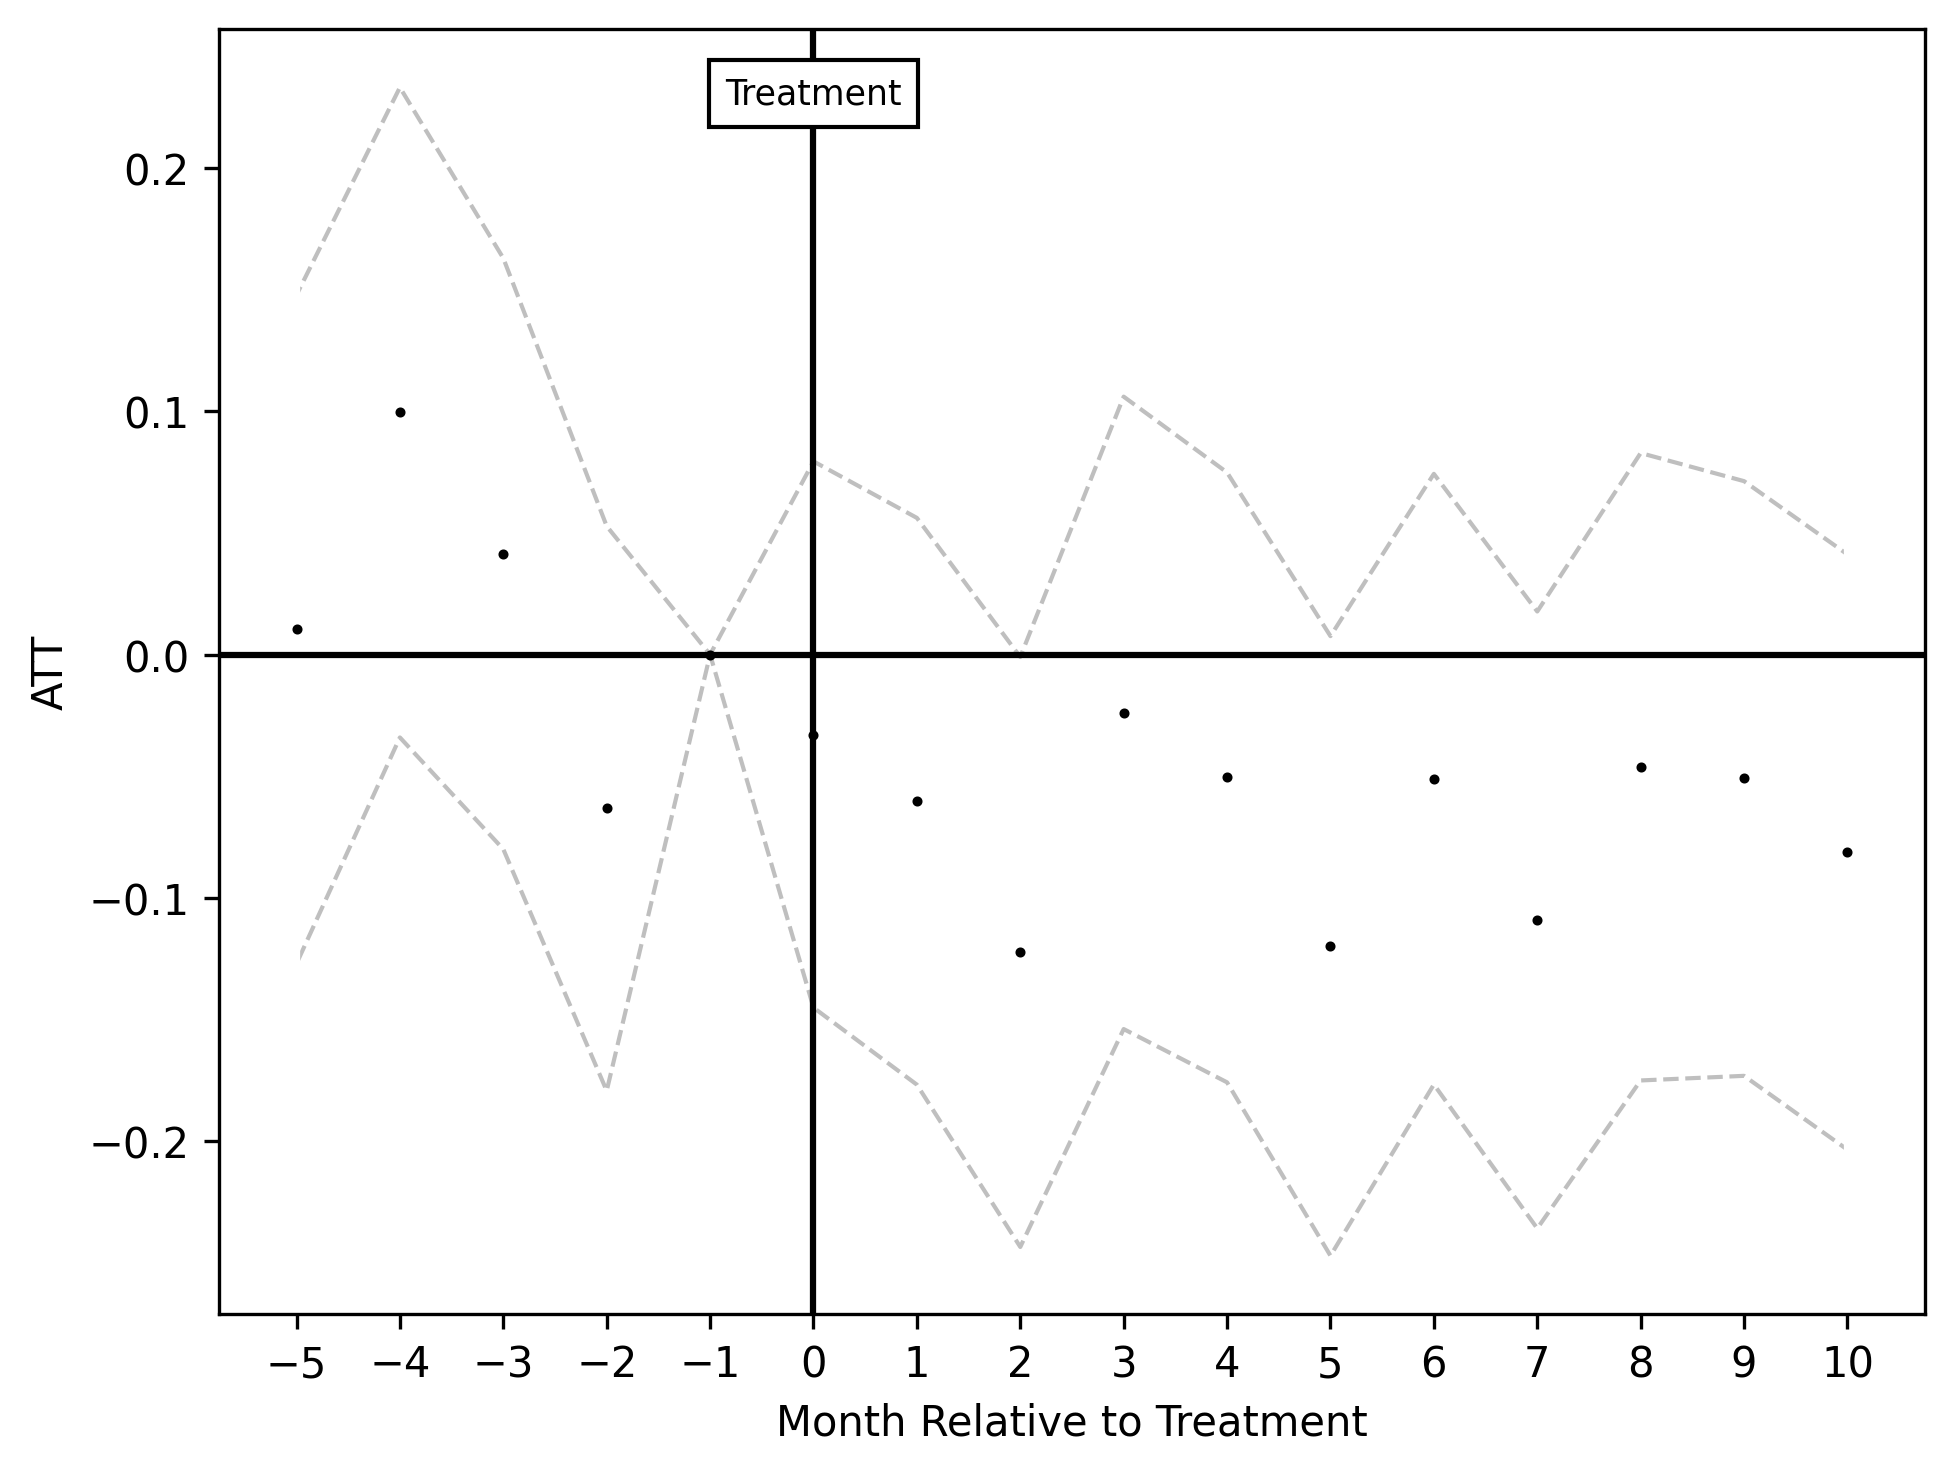

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-5, end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

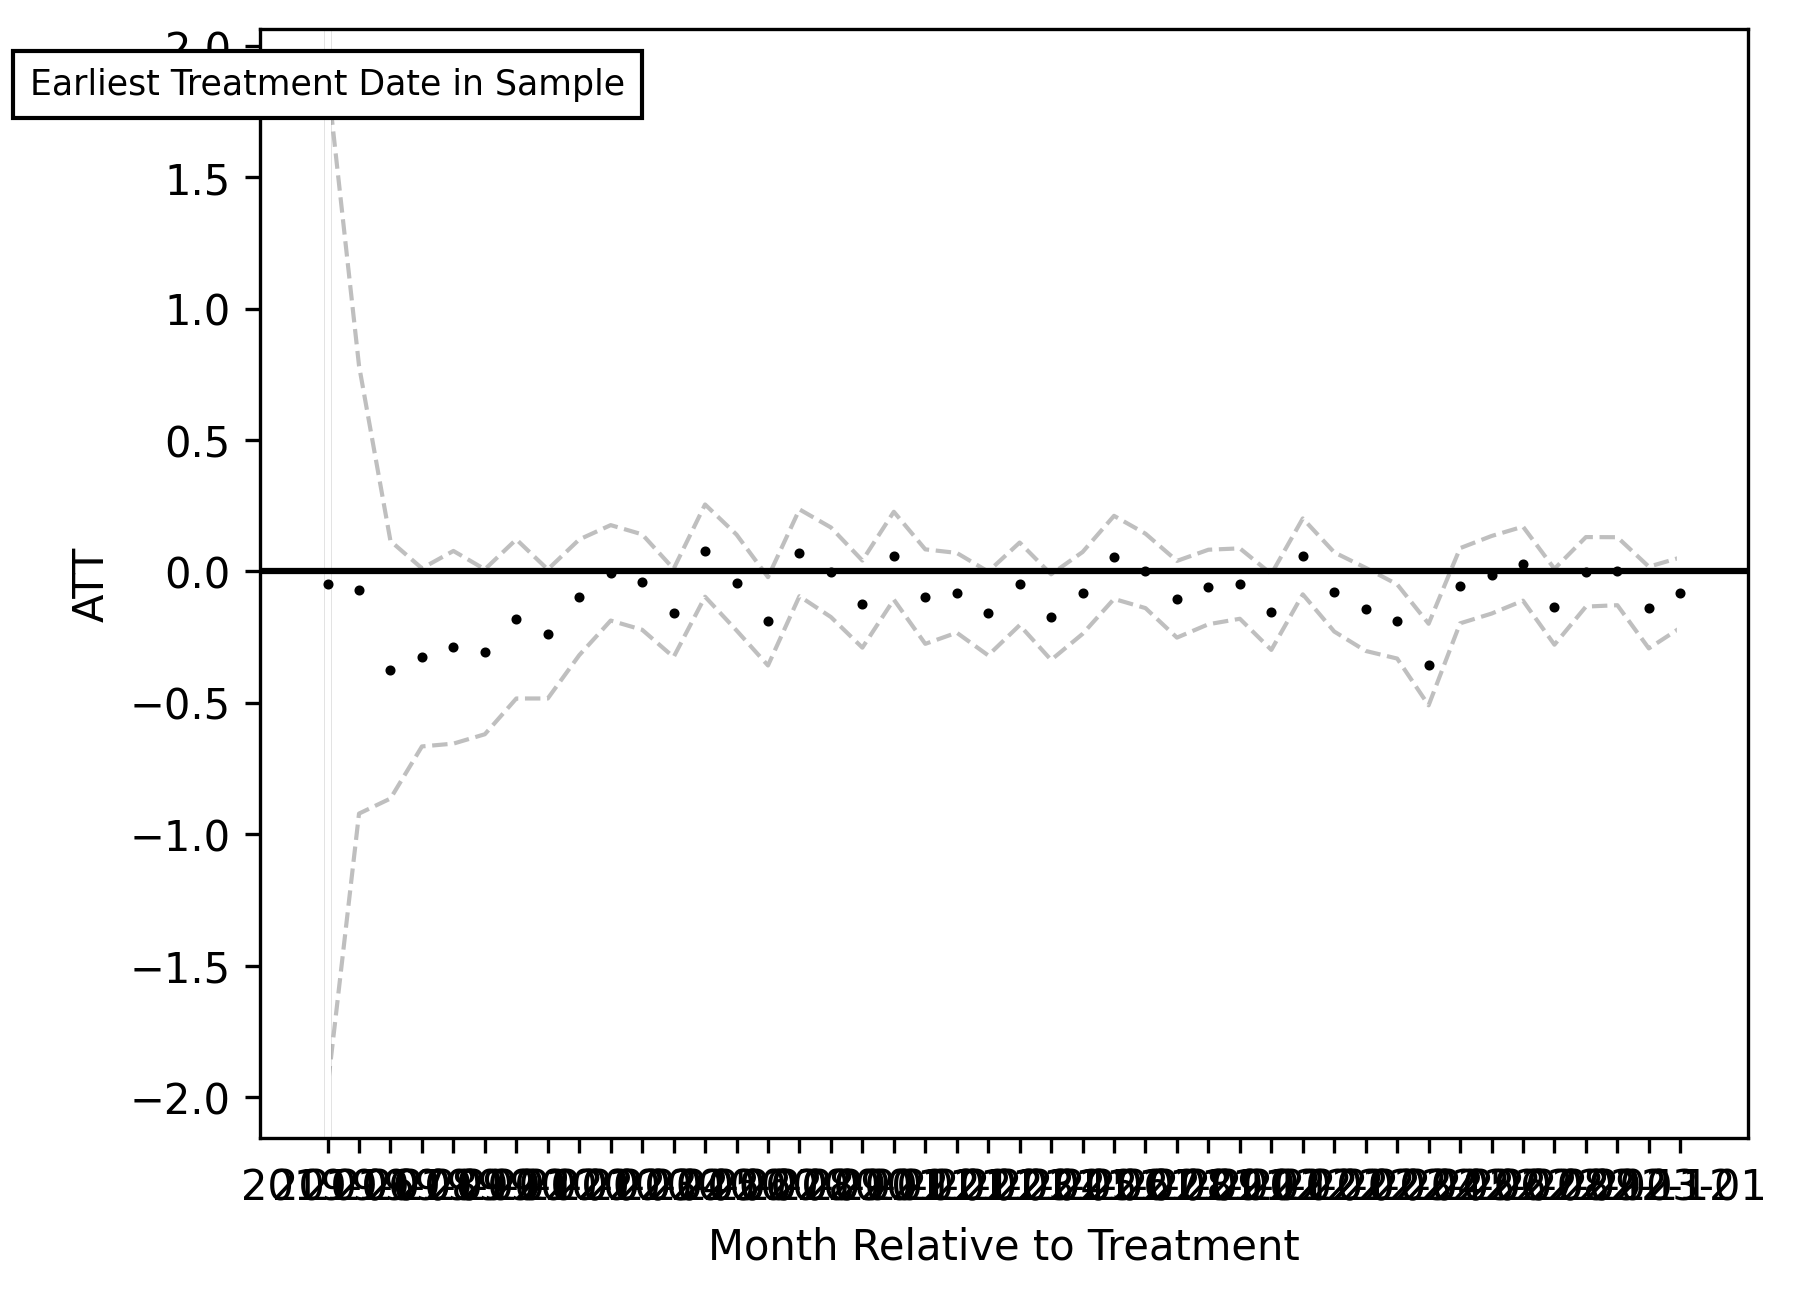

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=34]   94%|██████████████████▉ | 3562/3772 [00:16<00:00, 272.65it/s]/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-

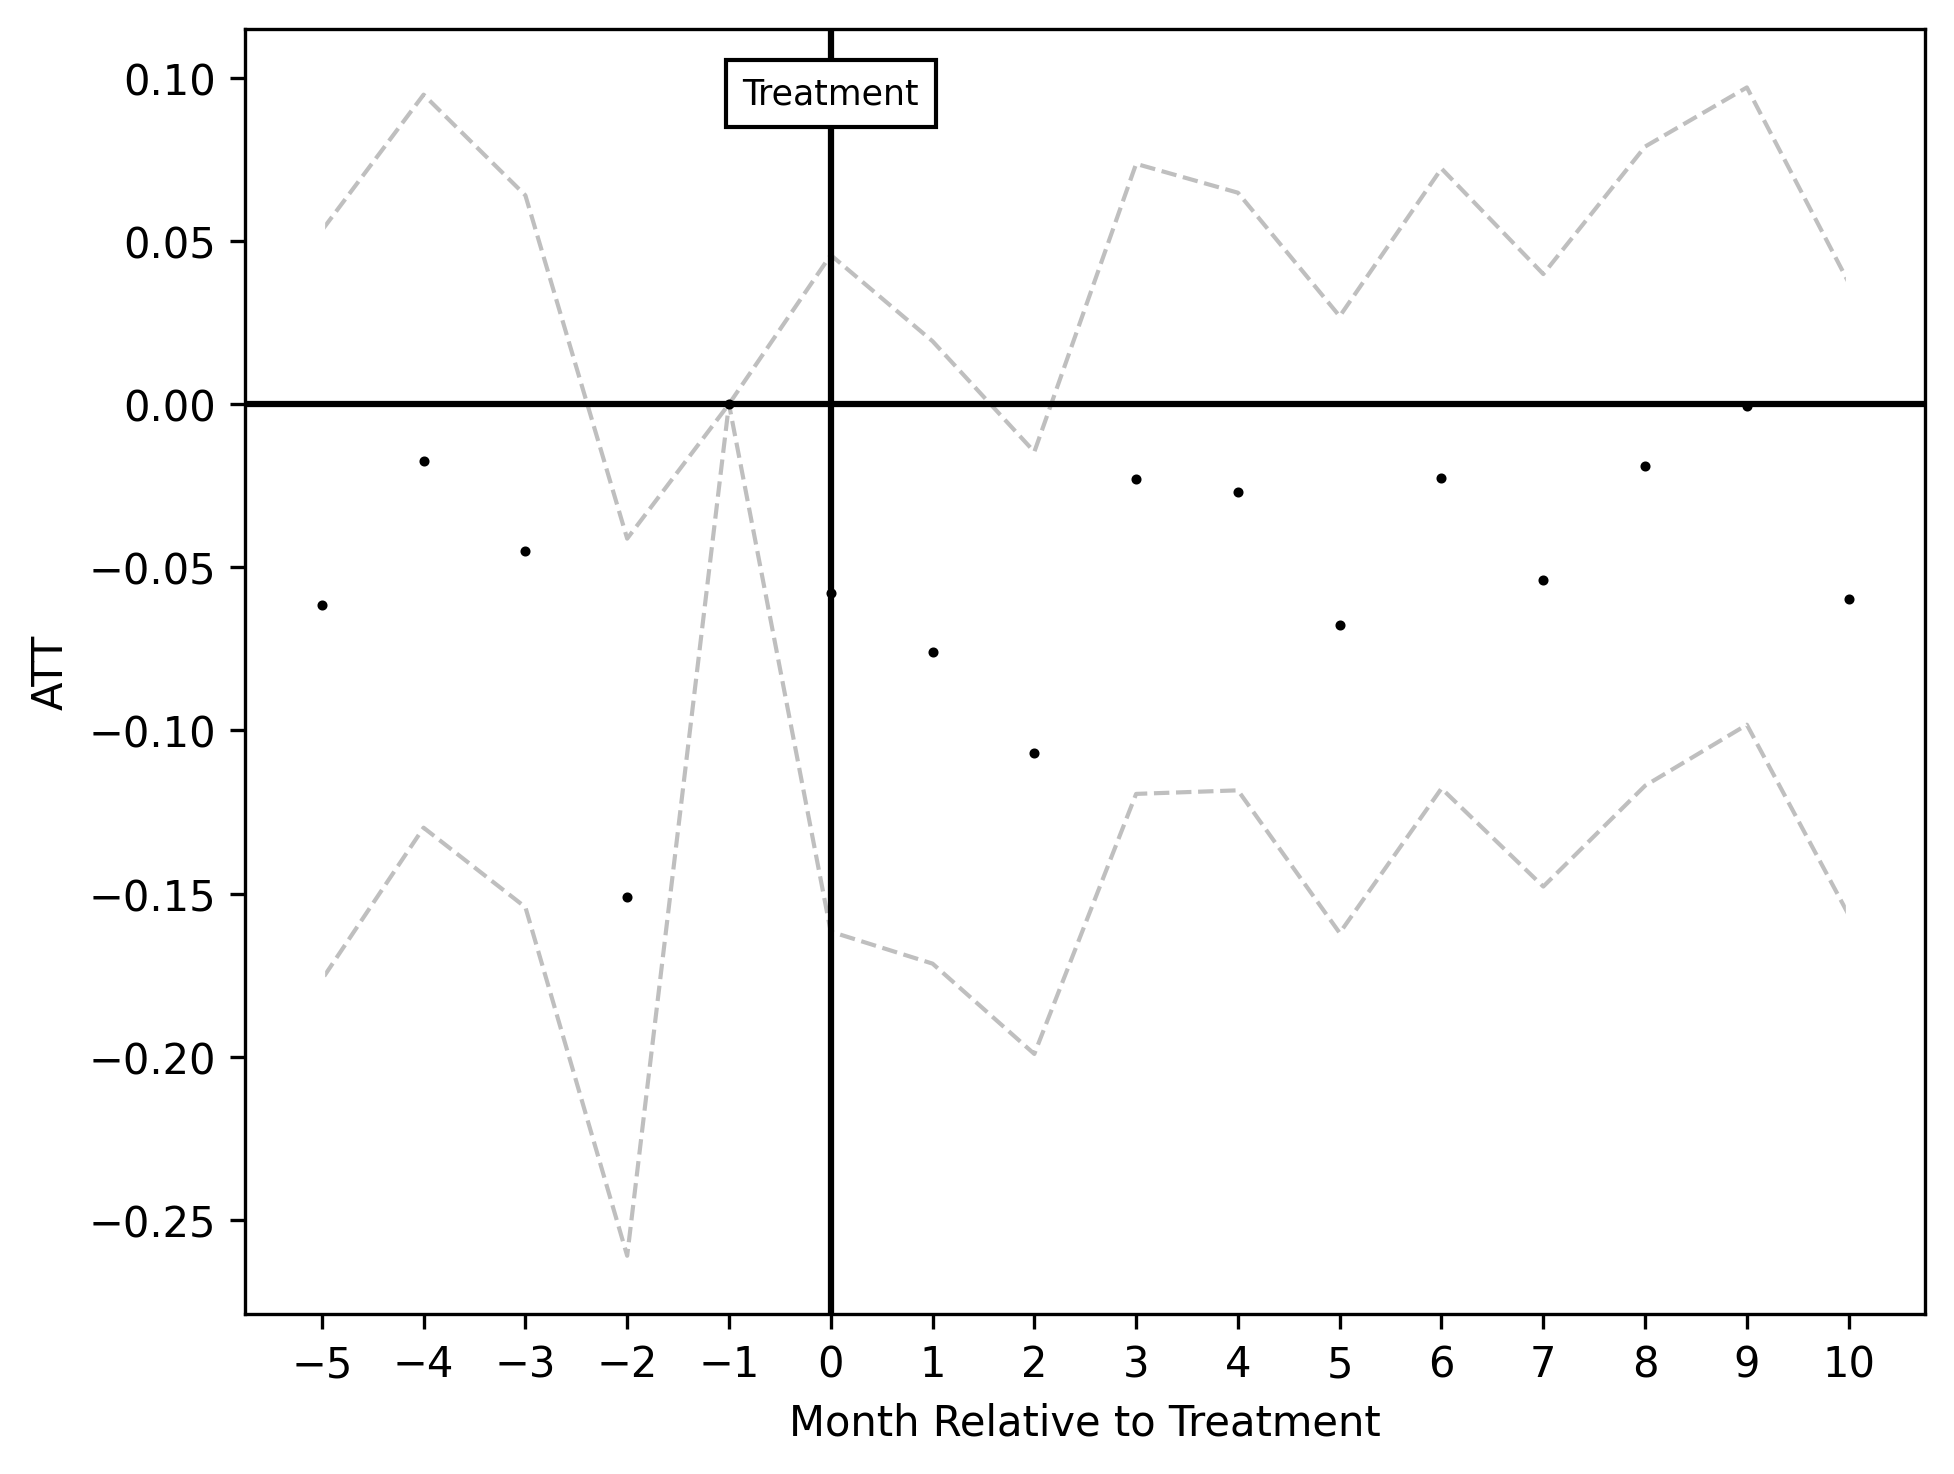

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-5,
                                 end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

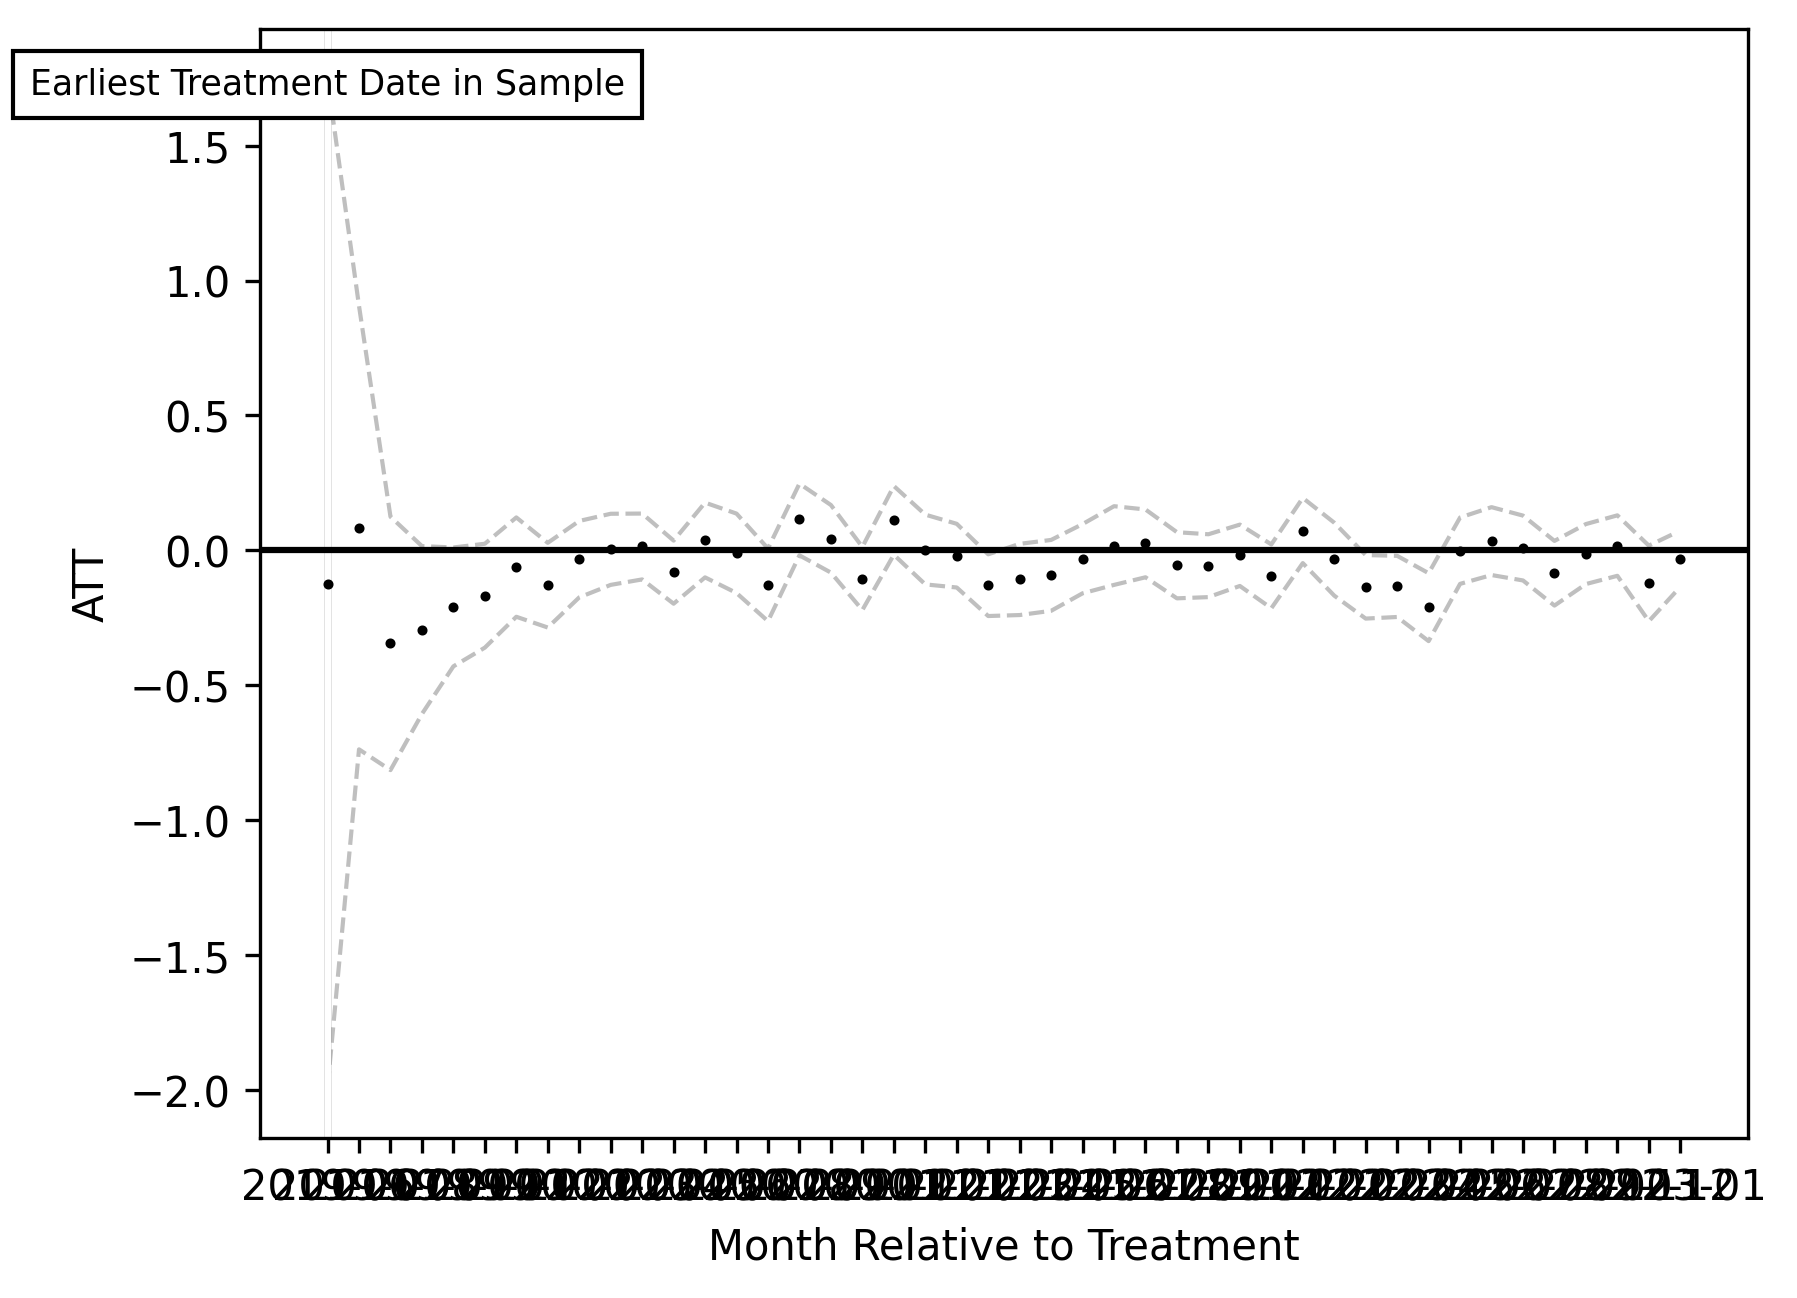

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")